# Quick Demo - ML Credit Scoring Platform

This notebook provides a quick demonstration of the ML loan eligibility platform.

## What this demo covers:
1. Loading sample data (transactions, airtime, loans)
2. Simple feature engineering
3. Training a Random Forest model
4. Model evaluation and predictions
5. Feature importance analysis

**Note**: This uses the sample Uganda data. For real PaySim data analysis, use the other numbered notebooks.

In [ ]:
!pip install seaborn

: 

In [2]:
import sys
from pathlib import Path

# Add project root to path
project_root = Path().resolve().parent
sys.path.insert(0, str(project_root))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, roc_auc_score, classification_report,
    confusion_matrix, roc_curve
)

# Set visualization style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ Libraries imported successfully!")
print("\n" + "="*80)
print("ML Loan Eligibility Platform - Quick Demo")
print("="*80)

✅ Libraries imported successfully!

ML Loan Eligibility Platform - Quick Demo


## Step 1: Load Sample Data

We'll load the sample Uganda financial data to demonstrate the platform capabilities.

In [3]:
print("Step 1: Loading sample data...")

# Load all data files
try:
    transactions = pd.read_csv("../data/raw/mobile_money_transactions.csv")
    airtime = pd.read_csv("../data/raw/airtime_purchases.csv")
    loans = pd.read_csv("../data/raw/loan_history.csv")
    target = pd.read_csv("../data/raw/loan_eligibility.csv")
    
    print(f"  ✓ Loaded {len(transactions):,} mobile money transactions")
    print(f"  ✓ Loaded {len(airtime):,} airtime purchases")
    print(f"  ✓ Loaded {len(loans):,} loan history records")
    print(f"  ✓ Loaded {len(target):,} users with eligibility labels")
    
    data_loaded = True
    
except FileNotFoundError as e:
    print(f"  ❌ Sample data files not found: {e}")
    print(f"  💡 Generate sample data first by running: python scripts/generate_uganda_data.py")
    data_loaded = False

print()

Step 1: Loading sample data...
  ✓ Loaded 5,614 mobile money transactions
  ✓ Loaded 1,655 airtime purchases
  ✓ Loaded 142 loan history records
  ✓ Loaded 100 users with eligibility labels



In [4]:
# Only proceed if data was loaded successfully
if not data_loaded:
    raise FileNotFoundError("Please generate sample data first: python scripts/generate_uganda_data.py")

# Display data info
print("Data Overview:")
print("-" * 40)

print("\nTransactions sample:")
print(transactions.head())

print("\nTransaction types:")
print(transactions['type'].value_counts())

print("\nTarget distribution:")
print(target['is_eligible'].value_counts())
print(f"Approval rate: {target['is_eligible'].mean():.1%}")

Data Overview:
----------------------------------------

Transactions sample:
    transaction_id user_id            timestamp      type     amount  \
0  TXN_user_0_0000  user_0  2025-05-14 13:41:31  incoming  114290.07   
1  TXN_user_0_0001  user_0  2025-05-17 17:27:43  incoming   75385.21   
2  TXN_user_0_0002  user_0  2025-05-21 13:37:53  outgoing  260248.32   
3  TXN_user_0_0003  user_0  2025-05-21 13:41:15  incoming  496495.20   
4  TXN_user_0_0004  user_0  2025-05-24 10:52:40  incoming  325243.92   

      balance         category merchant_id    merchant_name     location  \
0   370952.07  Business Income  MERCH_0609  Business Income  Fort Portal   
1   446337.28           Salary  MERCH_0235           Salary  Fort Portal   
2   186088.96      Street Food  MERCH_0112              NaN  Fort Portal   
3   682584.16           Salary  MERCH_0235           Salary  Fort Portal   
4  1007828.09   Freelance Work  MERCH_0050   Freelance Work  Fort Portal   

           provider  
0  MTN Mob

## Step 2: Simple Feature Engineering

We'll create basic behavioral features from the transaction data.

In [5]:
print("Step 2: Engineering features...")

# Transaction features per user
trans_features = transactions.groupby('user_id').agg({
    'amount': ['count', 'sum', 'mean', 'std', 'min', 'max'],
}).reset_index()
trans_features.columns = ['user_id', 'txn_count', 'txn_total', 'txn_mean',
                         'txn_std', 'txn_min', 'txn_max']

print(f"  ✓ Created basic transaction features")

# Incoming vs outgoing transactions
incoming = transactions[transactions['type'] == 'incoming'].groupby('user_id')['amount'].agg([
    ('income_total', 'sum'),
    ('income_avg', 'mean'),
    ('income_count', 'count')
]).reset_index()

outgoing = transactions[transactions['type'] == 'outgoing'].groupby('user_id')['amount'].agg([
    ('expense_total', 'sum'),
    ('expense_avg', 'mean'),
    ('expense_count', 'count')
]).reset_index()

print(f"  ✓ Created income/expense features")

# Balance features
balance_features = transactions.groupby('user_id')['balance'].agg([
    ('balance_avg', 'mean'),
    ('balance_min', 'min'),
    ('balance_max', 'max'),
    ('balance_std', 'std')
]).reset_index()

print(f"  ✓ Created balance features")

# Airtime features
airtime_features = airtime.groupby('user_id')['amount'].agg([
    ('airtime_total', 'sum'),
    ('airtime_avg', 'mean'),
    ('airtime_count', 'count')
]).reset_index()

print(f"  ✓ Created airtime features")

# Loan history features
loan_features = loans.groupby('user_id').agg({
    'loan_amount': [('prev_loans_count', 'count'), ('prev_loans_avg', 'mean')],
    'is_default': [('default_count', 'sum')]
}).reset_index()
loan_features.columns = ['user_id', 'prev_loans_count', 'prev_loans_avg', 'default_count']

print(f"  ✓ Created loan history features")

Step 2: Engineering features...
  ✓ Created basic transaction features
  ✓ Created income/expense features
  ✓ Created balance features
  ✓ Created airtime features
  ✓ Created loan history features


In [6]:
# Merge all features
features = trans_features.merge(incoming, on='user_id', how='left')
features = features.merge(outgoing, on='user_id', how='left')
features = features.merge(balance_features, on='user_id', how='left')
features = features.merge(airtime_features, on='user_id', how='left')
features = features.merge(loan_features, on='user_id', how='left')

# Fill missing values
features = features.fillna(0)

print(f"  ✓ Merged all features")
print(f"  ✓ Created {len(features.columns) - 1} total features")
print(f"  ✓ Feature set covers {len(features):,} users")

# Display feature names
feature_names = [c for c in features.columns if c != 'user_id']
print(f"\nFeature names: {feature_names}")

  ✓ Merged all features
  ✓ Created 22 total features
  ✓ Feature set covers 100 users

Feature names: ['txn_count', 'txn_total', 'txn_mean', 'txn_std', 'txn_min', 'txn_max', 'income_total', 'income_avg', 'income_count', 'expense_total', 'expense_avg', 'expense_count', 'balance_avg', 'balance_min', 'balance_max', 'balance_std', 'airtime_total', 'airtime_avg', 'airtime_count', 'prev_loans_count', 'prev_loans_avg', 'default_count']


## Step 3: Prepare Data for Training

In [8]:
print("Step 3: Preparing data for training...")

# Filter target to only include columns we need (like original demo.py)
target_clean = target[['user_id', 'is_eligible']]

# Merge features with target
data = features.merge(target_clean, on='user_id')
X = data.drop(columns=['user_id', 'is_eligible'])
y = data['is_eligible']

print(f"  ✓ Using only target columns: {list(target_clean.columns)}")
print(f"  ✓ Final feature columns: {list(X.columns)}")
print(f"  ✓ All features are numeric: {X.dtypes.apply(lambda x: x != 'object').all()}")

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"  ✓ Training set: {len(X_train):,} samples")
print(f"  ✓ Test set: {len(X_test):,} samples")
print(f"  ✓ Approval rate in training: {y_train.mean():.1%}")
print(f"  ✓ Approval rate in test: {y_test.mean():.1%}")
print(f"  ✓ Feature matrix shape: {X.shape}")

Step 3: Preparing data for training...
  ✓ Using only target columns: ['user_id', 'is_eligible']
  ✓ Final feature columns: ['txn_count', 'txn_total', 'txn_mean', 'txn_std', 'txn_min', 'txn_max', 'income_total', 'income_avg', 'income_count', 'expense_total', 'expense_avg', 'expense_count', 'balance_avg', 'balance_min', 'balance_max', 'balance_std', 'airtime_total', 'airtime_avg', 'airtime_count', 'prev_loans_count', 'prev_loans_avg', 'default_count']
  ✓ All features are numeric: True
  ✓ Training set: 80 samples
  ✓ Test set: 20 samples
  ✓ Approval rate in training: 51.2%
  ✓ Approval rate in test: 50.0%
  ✓ Feature matrix shape: (100, 22)


## Step 4: Train Random Forest Model

In [9]:
print("Step 4: Training Random Forest model...")

# Train Random Forest
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    class_weight='balanced',  # Handle class imbalance
    n_jobs=-1
)

model.fit(X_train, y_train)

print(f"  ✓ Model trained with {model.n_estimators} trees")
print(f"  ✓ Max depth: {model.max_depth}")
print(f"  ✓ Features used: {model.n_features_in_}")

Step 4: Training Random Forest model...
  ✓ Model trained with 100 trees
  ✓ Max depth: 10
  ✓ Features used: 22


## Step 5: Model Evaluation

In [10]:
print("Step 5: Evaluating model...")

# Make predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)

print(f"  ✓ Test Accuracy: {accuracy:.2%}")
print(f"  ✓ Test ROC-AUC: {auc:.4f}")

print("\nClassification Report:")
print("-" * 60)
print(classification_report(y_test, y_pred, target_names=['Not Eligible', 'Eligible']))

Step 5: Evaluating model...
  ✓ Test Accuracy: 85.00%
  ✓ Test ROC-AUC: 0.9300

Classification Report:
------------------------------------------------------------
              precision    recall  f1-score   support

Not Eligible       0.89      0.80      0.84        10
    Eligible       0.82      0.90      0.86        10

    accuracy                           0.85        20
   macro avg       0.85      0.85      0.85        20
weighted avg       0.85      0.85      0.85        20



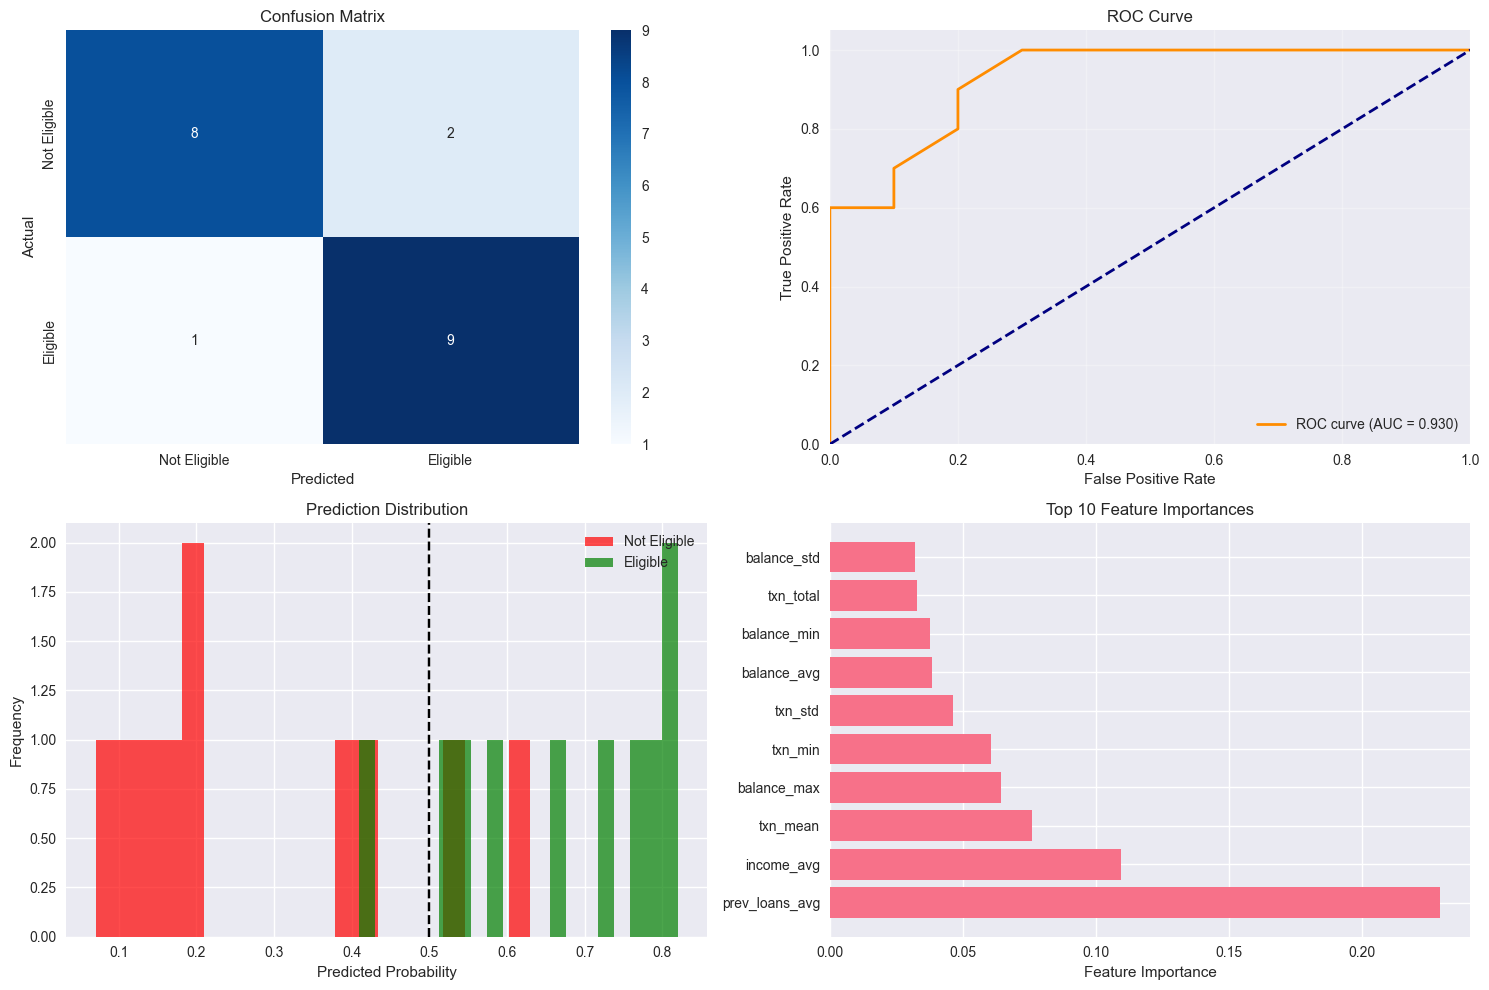

In [11]:
# Visualize results
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=['Not Eligible', 'Eligible'],
            yticklabels=['Not Eligible', 'Eligible'])
ax1.set_title('Confusion Matrix')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
ax2.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc:.3f})')
ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve')
ax2.legend(loc="lower right")
ax2.grid(True, alpha=0.3)

# Prediction Distribution
ax3.hist(y_pred_proba[y_test==0], bins=20, alpha=0.7, label='Not Eligible', color='red')
ax3.hist(y_pred_proba[y_test==1], bins=20, alpha=0.7, label='Eligible', color='green')
ax3.set_xlabel('Predicted Probability')
ax3.set_ylabel('Frequency')
ax3.set_title('Prediction Distribution')
ax3.legend()
ax3.axvline(0.5, color='black', linestyle='--', label='Decision Threshold')

# Feature Importance (Top 10)
importances = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

top_10 = importances.head(10)
ax4.barh(range(len(top_10)), top_10['importance'])
ax4.set_yticks(range(len(top_10)))
ax4.set_yticklabels(top_10['feature'])
ax4.set_xlabel('Feature Importance')
ax4.set_title('Top 10 Feature Importances')

plt.tight_layout()
plt.show()

## Step 6: Feature Importance Analysis

In [12]:
print("Top 10 Most Important Features:")
print("-" * 60)

for idx, row in importances.head(10).iterrows():
    print(f"  {row['feature']:25s}: {row['importance']:.4f}")

print(f"\nFeature importance insights:")
print(f"  • Most important: {importances.iloc[0]['feature']} ({importances.iloc[0]['importance']:.4f})")
print(f"  • Top 3 features account for {importances.head(3)['importance'].sum():.1%} of total importance")
print(f"  • Top 10 features account for {importances.head(10)['importance'].sum():.1%} of total importance")

Top 10 Most Important Features:
------------------------------------------------------------
  prev_loans_avg           : 0.2294
  income_avg               : 0.1094
  txn_mean                 : 0.0762
  balance_max              : 0.0645
  txn_min                  : 0.0607
  txn_std                  : 0.0465
  balance_avg              : 0.0385
  balance_min              : 0.0375
  txn_total                : 0.0328
  balance_std              : 0.0319

Feature importance insights:
  • Most important: prev_loans_avg (0.2294)
  • Top 3 features account for 41.5% of total importance
  • Top 10 features account for 72.7% of total importance


## Step 7: Sample Predictions

In [13]:
print("Sample Predictions:")
print("-" * 60)

# Get sample users
sample_users = X_test.head(10)
sample_preds = model.predict_proba(sample_users)[:, 1]
sample_decisions = (sample_preds >= 0.5).astype(int)
sample_actual = y_test.head(10).values

print(f"{'App #':<6} {'Decision':<10} {'Probability':<12} {'Actual':<8} {'Correct?'}")
print("-" * 60)

for i in range(len(sample_users)):
    decision = "APPROVE" if sample_decisions[i] else "REJECT"
    actual = "ELIGIBLE" if sample_actual[i] else "NOT ELIGIBLE"
    correct = "✓" if sample_decisions[i] == sample_actual[i] else "✗"
    prob = sample_preds[i]
    
    print(f"{i+1:<6} {decision:<10} {prob:<12.2%} {actual:<8} {correct}")

# Calculate accuracy on sample
sample_accuracy = (sample_decisions == sample_actual).mean()
print(f"\nSample accuracy: {sample_accuracy:.1%}")

Sample Predictions:
------------------------------------------------------------
App #  Decision   Probability  Actual   Correct?
------------------------------------------------------------
1      APPROVE    72.00%       ELIGIBLE ✓
2      APPROVE    54.00%       ELIGIBLE ✓
3      APPROVE    66.00%       ELIGIBLE ✓
4      REJECT     41.00%       ELIGIBLE ✗
5      APPROVE    63.00%       NOT ELIGIBLE ✗
6      REJECT     14.00%       NOT ELIGIBLE ✓
7      APPROVE    54.00%       NOT ELIGIBLE ✗
8      APPROVE    53.00%       ELIGIBLE ✓
9      REJECT     20.00%       NOT ELIGIBLE ✓
10     REJECT     18.00%       NOT ELIGIBLE ✓

Sample accuracy: 70.0%


## Summary & Next Steps

In [14]:
print("\n" + "="*80)
print("DEMO COMPLETE! 🎉")
print("="*80)

print(f"\n📊 Model Performance Summary:")
print(f"   • Accuracy: {accuracy:.2%}")
print(f"   • ROC-AUC: {auc:.4f}")
print(f"   • Features: {len(X.columns)}")
print(f"   • Training samples: {len(X_train):,}")

print(f"\n🔬 For Advanced Analysis, use these notebooks:")
print(f"   • 01_logistic_regression_model.ipynb - Interpretable coefficients")
print(f"   • 02_random_forest_model.ipynb - Ensemble feature importance")
print(f"   • 03_xgboost_model.ipynb - Gradient boosting with multiple importance types")
print(f"   • 04_lightgbm_model.ipynb - Fast and memory-efficient boosting")

print(f"\n🚀 For Production Training:")
print(f"   • Use PaySim dataset: python scripts/train_paysim_model.py")
print(f"   • 58+ behavioral features from 6M+ transactions")
print(f"   • Advanced class imbalance handling with SMOTE")

print(f"\n💡 This demo showed:")
print(f"   ✓ Basic feature engineering from financial data")
print(f"   ✓ Random Forest model training")
print(f"   ✓ Model evaluation and visualization")
print(f"   ✓ Feature importance analysis")
print(f"   ✓ Sample prediction workflow")


DEMO COMPLETE! 🎉

📊 Model Performance Summary:
   • Accuracy: 85.00%
   • ROC-AUC: 0.9300
   • Features: 22
   • Training samples: 80

🔬 For Advanced Analysis, use these notebooks:
   • 01_logistic_regression_model.ipynb - Interpretable coefficients
   • 02_random_forest_model.ipynb - Ensemble feature importance
   • 03_xgboost_model.ipynb - Gradient boosting with multiple importance types
   • 04_lightgbm_model.ipynb - Fast and memory-efficient boosting

🚀 For Production Training:
   • Use PaySim dataset: python scripts/train_paysim_model.py
   • 58+ behavioral features from 6M+ transactions
   • Advanced class imbalance handling with SMOTE

💡 This demo showed:
   ✓ Basic feature engineering from financial data
   ✓ Random Forest model training
   ✓ Model evaluation and visualization
   ✓ Feature importance analysis
   ✓ Sample prediction workflow
